In [1]:
from util import *

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
Connected DB CINS_SMY - conn
Connected oraDW_ANALYTICS - conn_aly


In [2]:
query = """WITH 
T0 AS (
    SELECT * FROM CINS_REACTIVATED_CASA_CUST_STT_CHG_01112023),
T1 AS (
    SELECT * FROM CINS_REACTIVATED_CASA_SCORE_01112023),
T2 AS (
    SELECT *
        FROM (SELECT T0.*, T1.SCORE, T1.RANK
        FROM T0 INNER JOIN T1 ON T0.CUSTOMER_CDE = T1.CUSTOMER_CDE
        ORDER BY SCORE DESC)),
T21 AS (
    SELECT * FROM DW_ANALYTICS.DW_CUST_PRODUCT_LOC_FCT
    WHERE SD_TKTT = 1 AND PROCESS_DT = TO_DATE('31-10-2023', 'DD-MM-YY')),
T3 AS (
    SELECT T21.*, T2.SCORE, T2.CUST_STT, T2.CUST_STT_LAG, T2.CUST_STT_CHG, T2.REACTIVATED
    FROM T21 
    INNER JOIN T2 ON T21.CUSTOMER_CDE = T2.CUSTOMER_CDE),
T4 AS (
    SELECT * FROM DW_ANALYTICS.DW_ORG_LOCATION_DIM),
T5 AS (
    SELECT * FROM DW_ANALYTICS.DW_CUSTOMER_FULL_DIM),
T6 AS (
    SELECT * FROM DW_ANALYTICS.DW_DEPOSIT_FCT),
T7 AS (
    SELECT * FROM DW_ANALYTICS.DW_LOAN_FCT),
T8 AS (
    SELECT * FROM DW_ANALYTICS.DW_SBVCODE_DIM),
T9 AS (
    SELECT * FROM DW_ANALYTICS.DW_CUSTOMER_DIM
    WHERE ACTIVE = 1),
T10 AS (
    SELECT * FROM CINS_FEATURE_STORE_REACTIVATED_01112023
    WHERE FTR_NM='CASA_DAY_SINCE_LAST_TXN_CT_36M'),
D1 AS (
    SELECT 
    T4.AREA_NAME, T5.SUB_BRANCH_CDE, T4.SUB_BRANCH_NAME, 
    T5.CUSTOMER_CDE, T5.FULL_NAME, T5.EMAIL, T5.MOBILE_PHONE, 
    T3.CUST_TYPE, T3.CUST_STATUS, T3.CUST_OPEN_DT,
    T3.TKTT, T3.TK, T3.VAY, T3.BH, T3.PAY, T3.IB, T3.MB, T3.SP_KHAC, 
    T3.LASTEST_TRANS_DT, T10.FTR_VAL AS CASA_DAY_SINCE_LAST_TXN,
    T9.DAO_CDE,
    T1.SCORE, T1.RANK, T3.REACTIVATED
    FROM T5
    INNER JOIN T3 ON T5.CUSTOMER_CDE = T3.CUSTOMER_CDE
    INNER JOIN T4 ON T5.SUB_BRANCH_CDE = T4.SUB_BRANCH_CDE
    INNER JOIN T1 ON T5.CUSTOMER_CDE = T1.CUSTOMER_CDE
    INNER JOIN T9 ON T5.CUSTOMER_CDE = T9.CUSTOMER_CDE
    INNER JOIN T10 ON T5.CUSTOMER_CDE = T10.CUSTOMER_CDE),
D2 AS (
    SELECT 
    T1.CUSTOMER_CDE, SUM(ACTUAL_BAL_LCL) AS TOTAL_BAL
    FROM T1 
    LEFT JOIN T6 ON T1.CUSTOMER_CDE = T6.CUSTOMER_CDE
    INNER JOIN T8 ON T8.SBVCODE_LVL_3 = T6.SBVCODE_LVL_3
    WHERE T8.APPLICATION = 'DP' AND T6.PROCESS_DT = TO_DATE('31-10-2023', 'DD-MM-YY')
    GROUP BY T1.CUSTOMER_CDE),
D3 AS (
    SELECT 
    T1.CUSTOMER_CDE, SUM(OS_AMT_LCL) AS TOTAL_LOAN
    FROM T1 
    LEFT JOIN T7 ON T1.CUSTOMER_CDE = T7.CUSTOMER_CDE
    INNER JOIN T8 ON T8.SBVCODE_LVL_3 = T7.SBVCODE_LVL_3
    WHERE T8.APPLICATION = 'LN' AND T7.PROCESS_DT = TO_DATE('31-10-2023', 'DD-MM-YY')
    GROUP BY T1.CUSTOMER_CDE),
D4 AS (
    SELECT 
    D1.AREA_NAME, D1.SUB_BRANCH_CDE, D1.SUB_BRANCH_NAME, 
    D1.CUSTOMER_CDE, D1.FULL_NAME, D1.EMAIL, D1.MOBILE_PHONE, 
    D1.CUST_TYPE, D1.CUST_STATUS, D1.CUST_OPEN_DT,
    D1.TKTT, D1.TK, D1.VAY, D1.BH, D1.PAY, D1.IB, D1.MB, D1.SP_KHAC, 
    NVL(D2.TOTAL_BAL, 0) AS TOTAL_BAL, 
    NVL(D3.TOTAL_LOAN, 0) AS TOTAL_LOAN,
    D1.LASTEST_TRANS_DT, 
    CASE WHEN D1.CASA_DAY_SINCE_LAST_TXN IS NULL THEN NULL ELSE ROUND(D1.CASA_DAY_SINCE_LAST_TXN / 30) END AS MONTH_TYPE,
    D1.DAO_CDE,
    D1.CASA_DAY_SINCE_LAST_TXN,
    D1.SCORE, D1.RANK, D1.REACTIVATED
    FROM D1 
    LEFT JOIN D2 ON D1.CUSTOMER_CDE = D2.CUSTOMER_CDE
    LEFT JOIN D3 ON D1.CUSTOMER_CDE = D3.CUSTOMER_CDE)
SELECT *
FROM D4
"""

In [3]:
portfolio = download_or_reload('data/PORTFOLIO_11_NOTREACTIVATED', query, update=False)

Len 9268694


In [4]:
portfolio['CASA_DAY_SINCE_LAST_TXN'] = portfolio['CASA_DAY_SINCE_LAST_TXN'].astype(int)

In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9268694 entries, 0 to 9268693
Data columns (total 27 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   AREA_NAME                object        
 1   SUB_BRANCH_CDE           object        
 2   SUB_BRANCH_NAME          object        
 3   CUSTOMER_CDE             object        
 4   FULL_NAME                object        
 5   EMAIL                    object        
 6   MOBILE_PHONE             object        
 7   CUST_TYPE                object        
 8   CUST_STATUS              object        
 9   CUST_OPEN_DT             datetime64[ns]
 10  TKTT                     int64         
 11  TK                       int64         
 12  VAY                      int64         
 13  BH                       float64       
 14  PAY                      float64       
 15  IB                       int64         
 16  MB                       int64         
 17  SP_KHAC                  fl

In [6]:
portfolio.sort_values(by='RANK')

,AREA_NAME,SUB_BRANCH_CDE,SUB_BRANCH_NAME,CUSTOMER_CDE,FULL_NAME,EMAIL,MOBILE_PHONE,CUST_TYPE,CUST_STATUS,CUST_OPEN_DT,...,SP_KHAC,TOTAL_BAL,TOTAL_LOAN,LASTEST_TRANS_DT,MONTH_TYPE,DAO_CDE,CASA_DAY_SINCE_LAST_TXN,SCORE,RANK,REACTIVATED
0,KV MIEN BAC,VN0011793,PGD SAO DO,18507460,VU TR3EV5R82887,ABCxxxxxxx@SACOMBANK.COM,037xxxxxx83,CN,HOAT DONG,2023-10-20,...,1.0,90634.0,990000000,2023-11-01,0,57469,1,0.989287,0,NaN
2,KV MIEN BAC,VN0011912,PGD PHAN CHU TRINH,18509899,BUI T3MUX92SUL7,ABCxxxxxxx@SACOMBANK.COM,097xxxxxx09,CN,HOAT DONG,2023-10-23,...,0.0,200004.0,0,2023-11-01,0,27399,1,0.989150,1,NaN
1,KV MIEN BAC,VN0011916,PGD YEN DINH - CNTHA,18513506,NGUYEEKO3PFVSGA,ABCxxxxxxx@SACOMBANK.COM,094xxxxxx96,CN,HOAT DONG,2023-10-24,...,0.0,194224.0,0,2023-11-01,0,55807,1,0.989150,2,NaN
3,KV MIEN BAC,VN0011911,CHI NHANH THANH HOA,18494026,LE TRLLVWBT3W2E,letxxxxxxx@gmail.com,090xxxxxx26,CN,HOAT DONG,2023-10-16,...,0.0,0.0,0,2023-10-30,0,30196,2,0.987469,3,NaN
4,KV MIEN BAC,VN0011911,CHI NHANH THANH HOA,18484891,NGUYE5CMZKE8JQK,ABCxxxxxxx@SACOMBANK.COM,035xxxxxx56,CN,HOAT DONG,2023-10-12,...,0.0,0.0,0,2023-10-28,0,30196,3,0.987428,4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9268689,KV MIEN BAC,VN0013142,PGD MONG CAI,7058387,LE MAP4PXZBWSO2,ABCxxxxxxx@SACOMBANK.COM,xxxxxx,CN,DONG BANG,2015-07-21,...,0.0,0.0,0,NaT,37,27213,1095,0.000155,8981946,0.0
9268690,KV NAM TRUNG BO - TAY NGUYEN,VN0011581,CHI NHANH KHANH HOA,6140218,THAI WX5D39K6NQ,ABCxxxxxxx@SACOMBANK.COM,091xxxxxx76,CN,DONG BANG,2015-03-05,...,0.0,5681.0,1333310000,2023-10-31,37,23344,1095,0.000155,8981947,NaN
9268691,KV MIEN BAC,VN0011526,PGD VAN GIANG-CN HYN,10007902,KH VAIFTUDMB6ZI,,xxxxxx,CN,NGU DONG,2016-12-28,...,0.0,0.0,0,NaT,37,1,1095,0.000123,8981948,0.0
9268692,KV TP.HA NOI,VN0014331,PGD PHUONG MAI,11402106,HO KIFAV38MY5EB,TBYxxxxxxx@GMAIL.COM,xxxxxx,CN,HOAT DONG,2018-01-04,...,0.0,3805.0,0,2023-04-01,7,33396,215,0.000106,8981949,NaN


In [7]:
portfolio['CUST_STATUS'].value_counts(dropna=False)

HOAT DONG    8098405
NGU DONG      928484
DONG BANG     241805
Name: CUST_STATUS, dtype: int64

In [8]:
portfolio = portfolio[portfolio['CUST_STATUS'].isin(['NGU DONG', 'DONG BANG'])]
portfolio.shape

(1170289, 27)

In [9]:
portfolio['REACTIVATED'].value_counts(dropna=False)

0.0    995451
NaN     99629
1.0     75209
Name: REACTIVATED, dtype: int64

In [10]:
# d1 include d2
d1 = portfolio.sort_values(by='SCORE', ascending=False)
d1

,AREA_NAME,SUB_BRANCH_CDE,SUB_BRANCH_NAME,CUSTOMER_CDE,FULL_NAME,EMAIL,MOBILE_PHONE,CUST_TYPE,CUST_STATUS,CUST_OPEN_DT,...,SP_KHAC,TOTAL_BAL,TOTAL_LOAN,LASTEST_TRANS_DT,MONTH_TYPE,DAO_CDE,CASA_DAY_SINCE_LAST_TXN,SCORE,RANK,REACTIVATED
24,KV MIEN BAC,VN0012546,PGD THUY NGUYEN-CN HP,18535516,PHAM SYLPXHJQSC,ABCxxxxxxx@SACOMBANK.COM,034xxxxxx07,CN,NGU DONG,2023-10-31,...,0.0,0.0,0,NaT,37,78822,1095,0.973863,30,1.0
30,KV MIEN BAC,VN0012546,PGD THUY NGUYEN-CN HP,18535560,DO DUZ0LOBQRZB1,ABCxxxxxxx@SACOMBANK.COM,056xxxxxx60,CN,NGU DONG,2023-10-31,...,0.0,0.0,0,NaT,37,78822,1095,0.973863,24,1.0
33,KV MIEN BAC,VN0012546,PGD THUY NGUYEN-CN HP,18535552,HOANGAP1QG861JX,ABCxxxxxxx@SACOMBANK.COM,086xxxxxx01,CN,NGU DONG,2023-10-31,...,0.0,0.0,0,NaT,37,78822,1095,0.973863,25,1.0
32,KV MIEN BAC,VN0012546,PGD THUY NGUYEN-CN HP,18535561,NGUYEWXZXU9L2AA,ABCxxxxxxx@SACOMBANK.COM,035xxxxxx16,CN,NGU DONG,2023-10-31,...,0.0,0.0,0,NaT,37,78822,1095,0.973863,31,1.0
31,KV MIEN BAC,VN0011796,PGD THANH MIEN,18531927,TRAN D0270QI10B,ABCxxxxxxx@SACOMBANK.COM,096xxxxxx50,CN,NGU DONG,2023-10-30,...,0.0,0.0,0,NaT,37,71282,1095,0.973863,28,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9268688,KV MIEN BAC,VN0011915,PGD NGHI SON,2344333,KH VATXF4UF6XWN,,xxxxxx,CN,NGU DONG,2011-07-11,...,0.0,0.0,0,NaT,37,17474,1095,0.000166,8981945,0.0
9268689,KV MIEN BAC,VN0013142,PGD MONG CAI,7058387,LE MAP4PXZBWSO2,ABCxxxxxxx@SACOMBANK.COM,xxxxxx,CN,DONG BANG,2015-07-21,...,0.0,0.0,0,NaT,37,27213,1095,0.000155,8981946,0.0
9268690,KV NAM TRUNG BO - TAY NGUYEN,VN0011581,CHI NHANH KHANH HOA,6140218,THAI WX5D39K6NQ,ABCxxxxxxx@SACOMBANK.COM,091xxxxxx76,CN,DONG BANG,2015-03-05,...,0.0,5681.0,1333310000,2023-10-31,37,23344,1095,0.000155,8981947,NaN
9268691,KV MIEN BAC,VN0011526,PGD VAN GIANG-CN HYN,10007902,KH VAIFTUDMB6ZI,,xxxxxx,CN,NGU DONG,2016-12-28,...,0.0,0.0,0,NaT,37,1,1095,0.000123,8981948,0.0


In [11]:
d1['REACTIVATED'].value_counts()

0.0    995451
1.0     75209
Name: REACTIVATED, dtype: int64

## AUC

In [12]:
from sklearn import metrics
tmp = d1[['REACTIVATED', 'SCORE']].dropna()
auc = metrics.roc_auc_score(tmp['REACTIVATED'], tmp['SCORE'])
auc

0.6427457059917965

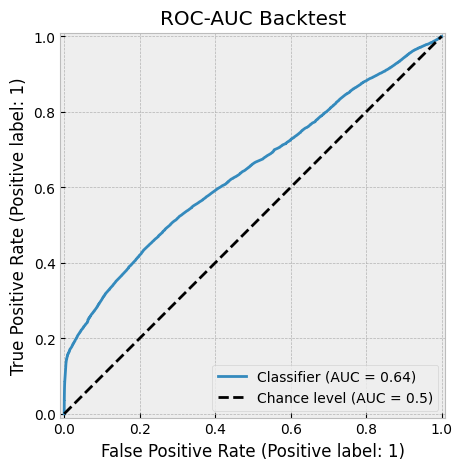

In [13]:
fig, axs = plt.subplots(1,1, figsize=(5, 5))
metrics.RocCurveDisplay.from_predictions(tmp['REACTIVATED'], tmp['SCORE'], plot_chance_level=True, ax=axs)
axs.set_title('ROC-AUC Backtest')
plt.grid = True
plt.show()

## BINNING

In [14]:
num_buckets = 10

In [15]:
d1['BUCKET'], bins = pd.qcut(d1['SCORE'], num_buckets, labels=range(10, 0, -1), retbins=True)
d1['BUCKET'] = d1['BUCKET'].astype(int)

In [16]:
d1['BUCKET'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [17]:
d1['BUCKET'].value_counts().sort_index()

1     117029
2     117008
3     117039
4     117038
5     117023
6     114896
7     119169
8     117029
9     117029
10    117029
Name: BUCKET, dtype: int64

In [18]:
bins

array([9.37422301e-05, 2.13489081e-03, 4.47900416e-03, 7.22974371e-03,
       9.96535178e-03, 1.18185543e-02, 1.39679005e-02, 1.65905245e-02,
       2.25990415e-02, 3.47955465e-02, 9.73862827e-01])

In [19]:
tmp = d1[['REACTIVATED', 'BUCKET']].dropna()
tmp['REACTIVATED'] = tmp['REACTIVATED'].astype(int)
tmp = tmp.groupby('BUCKET')['REACTIVATED'].value_counts().to_frame('num_cust').reset_index().pivot(index='BUCKET', columns='REACTIVATED', values='num_cust')
tmp['TOTAL_LEAD'] = tmp[0] + tmp[1]
tmp

REACTIVATED,0,1,TOTAL_LEAD
BUCKET,,,
1,75859,20171,96030
2,91316,8709,100025
3,96351,7651,104002
4,104081,6260,110341
5,105426,5584,111010
6,103720,5225,108945
7,104373,5955,110328
8,101716,6169,107885
9,104535,4714,109249


In [20]:
total_reactivated = tmp[1].sum()
total_leads = tmp['TOTAL_LEAD'].sum()
total_leads, total_reactivated

(1070660, 75209)

In [21]:
tmp['perc_REACTIVATED'] = tmp[1] / total_reactivated * 100
tmp['cumsum_REACTIVATED'] = tmp[1].cumsum()
tmp['perc_cumsum_REACTIVATED'] = tmp['cumsum_REACTIVATED'] / total_reactivated * 100
tmp['lift'] = tmp['perc_cumsum_REACTIVATED'] / (tmp['TOTAL_LEAD'].cumsum() / total_leads)  / 100

In [22]:
tmp

REACTIVATED,0,1,TOTAL_LEAD,perc_REACTIVATED,cumsum_REACTIVATED,perc_cumsum_REACTIVATED,lift
BUCKET,,,,,,,
1,75859,20171,96030,26.819928,20171,26.819928,2.990214
2,91316,8709,100025,11.579731,28880,38.399660,2.097013
3,96351,7651,104002,10.172985,36531,48.572644,1.733164
4,104081,6260,110341,8.323472,42791,56.896116,1.484325
5,105426,5584,111010,7.424643,48375,64.320759,1.320763
6,103720,5225,108945,6.947307,53600,71.268066,1.210494
7,104373,5955,110328,7.917935,59555,79.186002,1.144640
8,101716,6169,107885,8.202476,65724,87.388477,1.102605
9,104535,4714,109249,6.267867,70438,93.656344,1.046905


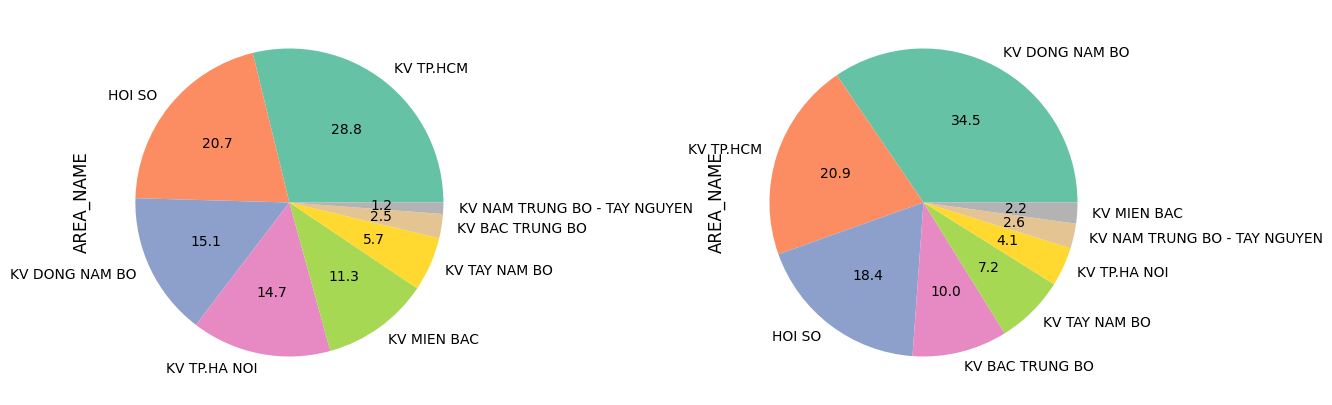

In [23]:
f, axs = plt.subplots(1, 2, figsize=(15,5))
d1[d1['REACTIVATED']==1]['AREA_NAME'].value_counts().sort_values(ascending=False).plot(kind='pie', autopct='%.1f', colormap='Set2', ax=axs[0])
d1[(d1['BUCKET']==1) & (d1['REACTIVATED']==0)]['AREA_NAME'].value_counts().sort_values(ascending=False).plot(kind='pie', autopct='%.1f', colormap='Set2', ax=axs[1])
# d2[d2['BUCKET']==1]['AREA_NAME'].value_counts().sort_values(ascending=False).plot(kind='pie', autopct='%.1f', colormap='Set2', ax=axs[2])
plt.show()

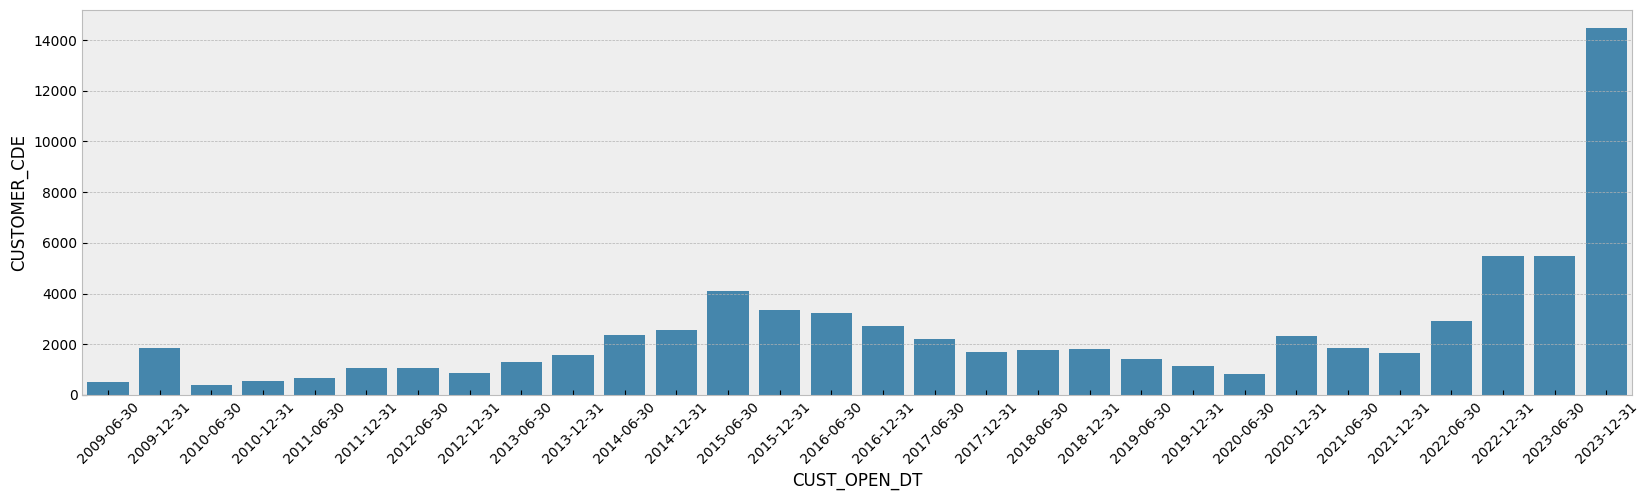

In [24]:
tmp = d1[d1['REACTIVATED']==1]
# tmp = tmp.set_index('CUST_OPEN_DT').sort_index()
tmp1 = (tmp.reset_index().groupby([pd.Grouper(key='CUST_OPEN_DT', axis=0,freq='3M', sort=True)])['CUSTOMER_CDE'].nunique() / len(tmp)).to_frame('prop').reset_index()
tmp1 = tmp.groupby(pd.Grouper(key='CUST_OPEN_DT', axis=0,freq='6M', sort=True))['CUSTOMER_CDE'].nunique().reset_index()

fig, ax = plt.subplots(1,1, figsize=(20, 5))
ax = sns.barplot(tmp1, x='CUST_OPEN_DT',y='CUSTOMER_CDE',
                #  palette=['springgreen', 'cyan', 'dodgerblue'], 
                #  hue_order=['1. HOAT DONG', '2. NGU DONG', '3. DONG BANG'],
                )
ax.tick_params(axis='x', rotation=45)
plt.show()

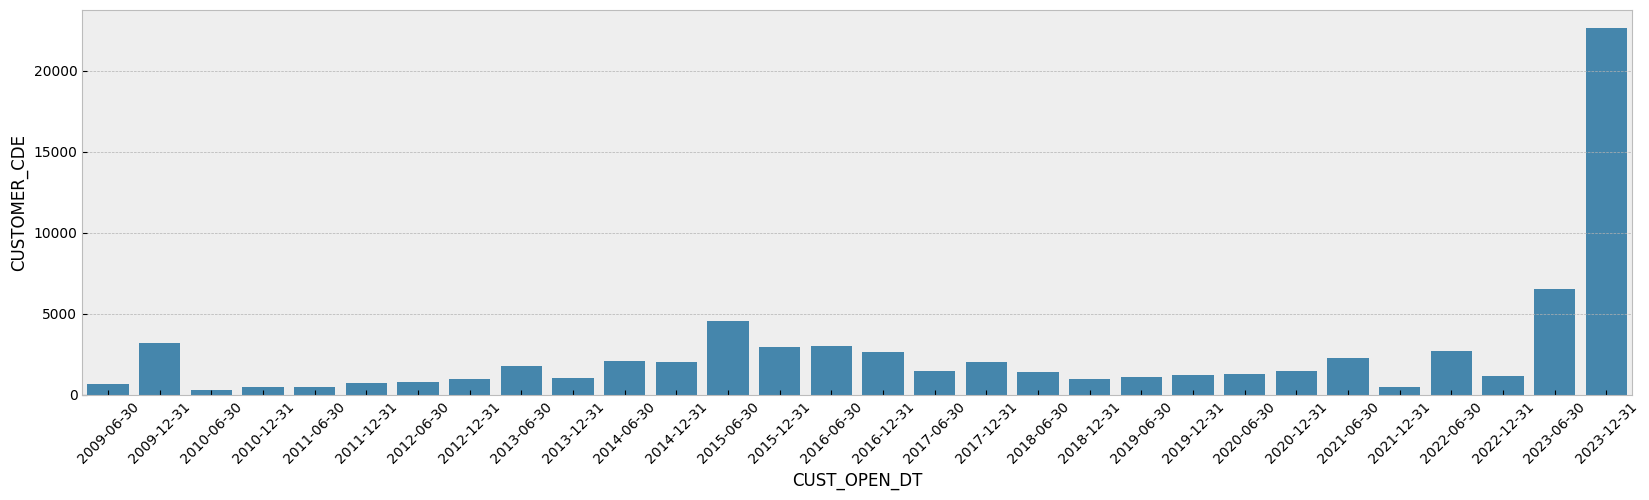

In [25]:
tmp = d1[(d1['BUCKET']==1) & (d1['REACTIVATED']==0)]
# tmp = tmp.set_index('CUST_OPEN_DT').sort_index()
tmp1 = (tmp.reset_index().groupby([pd.Grouper(key='CUST_OPEN_DT', axis=0,freq='3M', sort=True)])['CUSTOMER_CDE'].nunique() / len(tmp)).to_frame('prop').reset_index()
tmp1 = tmp.groupby(pd.Grouper(key='CUST_OPEN_DT', axis=0,freq='6M', sort=True))['CUSTOMER_CDE'].nunique().reset_index()

fig, ax = plt.subplots(1,1, figsize=(20, 5))
ax = sns.barplot(tmp1, x='CUST_OPEN_DT',y='CUSTOMER_CDE',
                #  palette=['springgreen', 'cyan', 'dodgerblue'], 
                #  hue_order=['1. HOAT DONG', '2. NGU DONG', '3. DONG BANG'],
                )
ax.tick_params(axis='x', rotation=45)
plt.show()

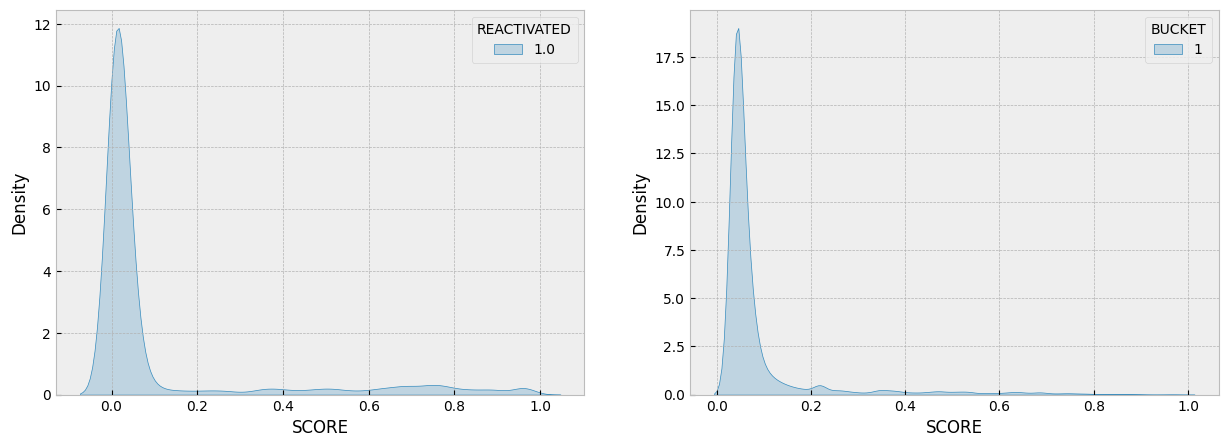

In [26]:
f, axs = plt.subplots(1,2,figsize=(15,5))
tmp = d1[d1['REACTIVATED']==1]
sns.kdeplot(tmp, x='SCORE', hue='REACTIVATED', fill=True, common_norm=False, ax=axs[0])
tmp = d1[(d1['BUCKET']==1) & (d1['REACTIVATED']==0)]
sns.kdeplot(tmp, x='SCORE', hue='BUCKET', fill=True, common_norm=False, ax=axs[1])
# sns.kdeplot(d2, x='SCORE', hue='BUCKET', fill=True, common_norm=False, alpha=0.3, linewidth=0.3, palette='crest', ax=axs[2])
plt.show()

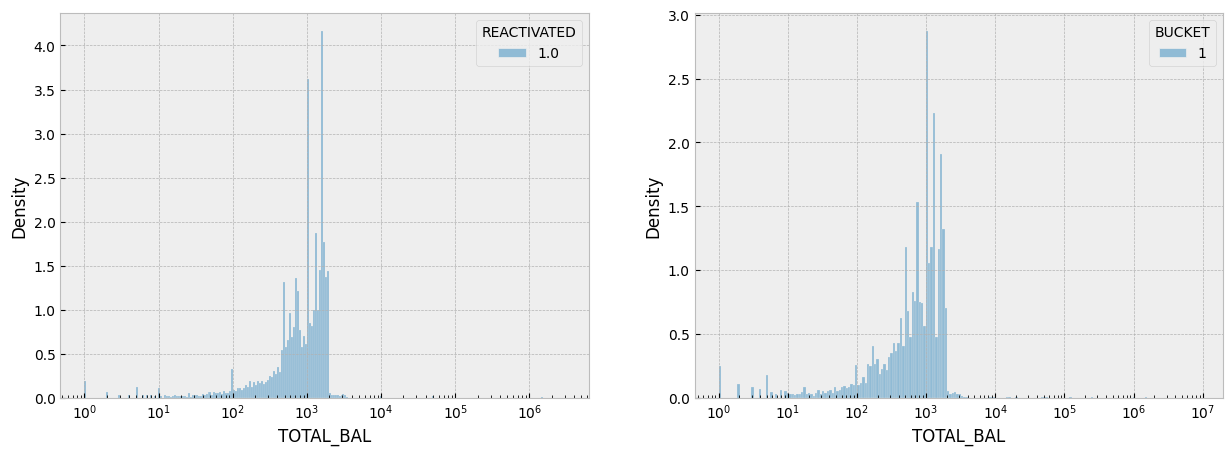

In [27]:
f, axs = plt.subplots(1,2,figsize=(15,5))
tmp = d1[d1['REACTIVATED']==1]
sns.histplot(tmp, x='TOTAL_BAL', hue='REACTIVATED', log_scale=True, stat='density', common_norm=False,ax=axs[0])
tmp = d1[(d1['BUCKET']==1) & (d1['REACTIVATED']==0)]
sns.histplot(tmp, x='TOTAL_BAL', hue='BUCKET', log_scale=True, stat='density', common_norm=False,ax=axs[1])
# sns.histplot(d2, x='TOTAL_BAL', hue='BUCKET', log_scale=True, stat='density', common_norm=False,palette='crest',ax=axs[2])
plt.show()

0
0


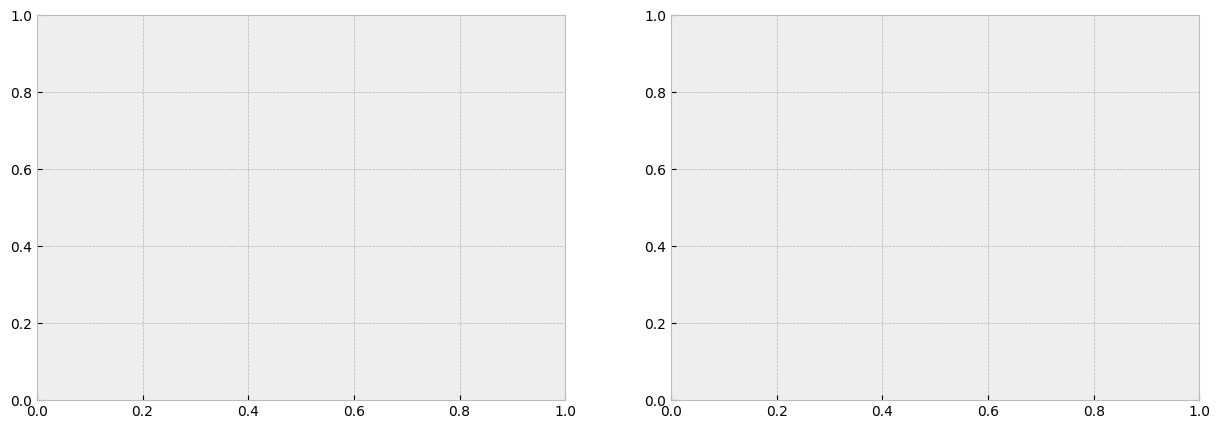

In [51]:
f, axs = plt.subplots(1,2,figsize=(15,5))
tmp = d1[d1['REACTIVATED']==1]
tmp = tmp[tmp['TOTAL_LOAN']>0]
print(len(tmp))
# sns.kdeplot(tmp, x='TOTAL_LOAN', hue='REACTIVATED', log_scale=False, ax=axs[0])

tmp = d1[(d1['BUCKET']==1) & (d1['REACTIVATED']==0)]
tmp = tmp[tmp['TOTAL_LOAN']>0]
print(len(tmp))
# sns.kdeplot(tmp, x='TOTAL_LOAN', hue='BUCKET', log_scale=False, ax=axs[1])
# sns.histplot(d2, x='TOTAL_LOAN', hue='BUCKET', log_scale=True, stat='density',palette='crest', alpha=0.3, ax=axs[2])
# axs[0].set_xlim([0, 1e10])
# axs[1].set_xlim([0, 1e10])
plt.show()

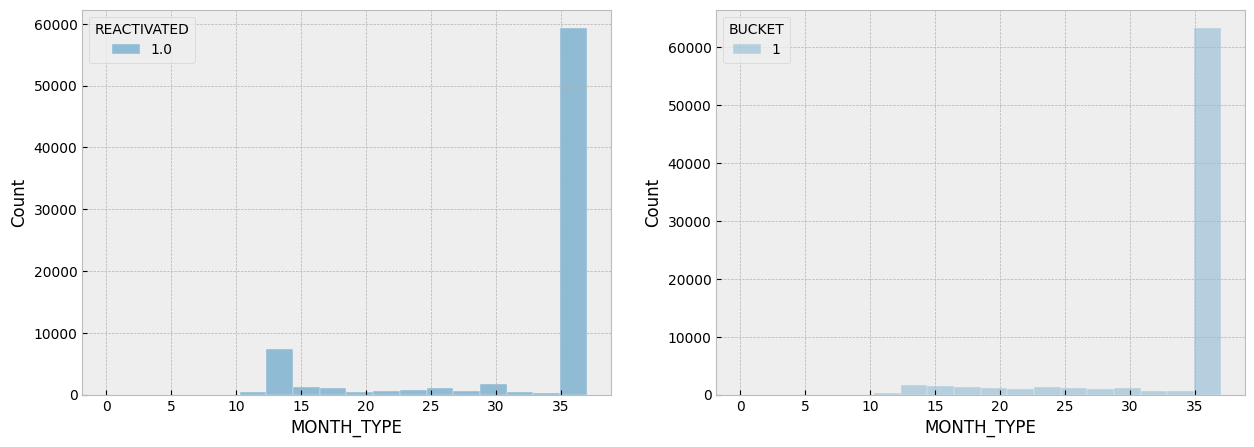

In [29]:
f, axs = plt.subplots(1,2,figsize=(15,5))
tmp = d1[d1['REACTIVATED']==1]
sns.histplot(tmp, x='MONTH_TYPE', hue='REACTIVATED', fill=True, stat='count',common_norm=True, linewidth=0.3,ax=axs[0])
tmp = d1[(d1['BUCKET']==1) & (d1['REACTIVATED']==0)]
sns.histplot(tmp, x='MONTH_TYPE', hue='BUCKET', fill=True, stat='count',common_norm=True, alpha=0.3, linewidth=0.3,ax=axs[1])
# sns.histplot(d2, x='MONTH_TYPE', hue='BUCKET', fill=True, stat='count',common_norm=True, alpha=0.3, linewidth=0.3,palette='crest', ax=axs[2])
plt.show()


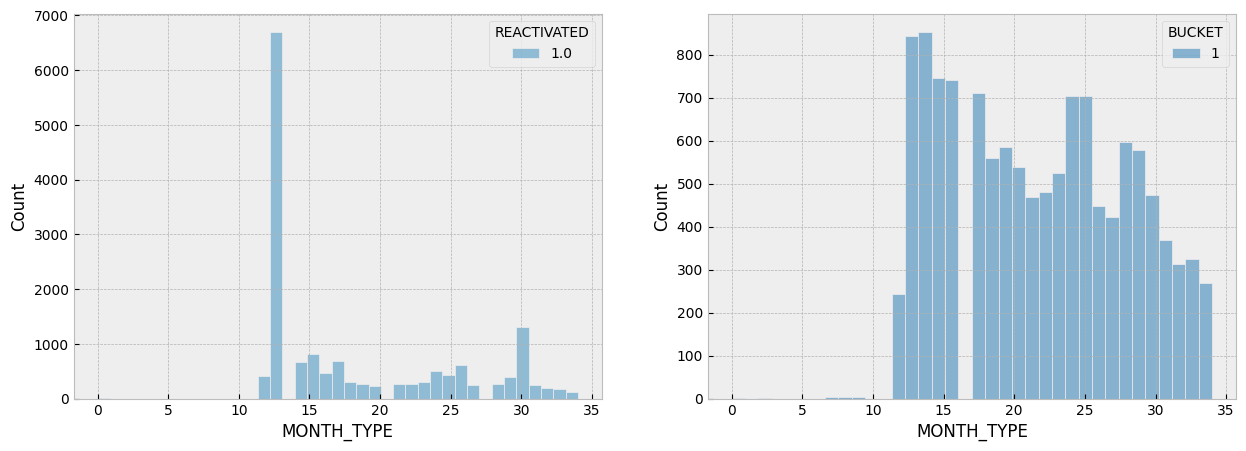

In [43]:
f, axs = plt.subplots(1,2,figsize=(15,5))
d1['MONTH_TYPE'] = d1['MONTH_TYPE'].astype(int)
tmp = d1[d1['REACTIVATED']==1]
tmp = tmp[tmp['MONTH_TYPE']<37]
sns.histplot(tmp,x='MONTH_TYPE', hue='REACTIVATED',common_norm=False,ax=axs[0])
# tmp = d1[(d1['BUCKET']>7) & (d1['MONTH_TYPE']<37) & (d1['MONTH_TYPE']>1)].copy()
tmp = d1[(d1['BUCKET']==1) & (d1['REACTIVATED']==0)]
tmp = tmp[tmp['MONTH_TYPE']<37]
sns.histplot(tmp,x='MONTH_TYPE', hue='BUCKET',common_norm=False, palette='tab10',ax=axs[1])
# sns.kdeplot(d2[(d2['MONTH_TYPE']<37) & (d2['MONTH_TYPE']>1) & (d2['BUCKET']>7)],x='MONTH_TYPE', hue='BUCKET',common_norm=False, palette='tab10',ax=axs[2])
plt.show()

# MAPPING SCORE WITH NEW CUSTOMERS

In [31]:
d2 = portfolio[(portfolio['REACTIVATED'].isnull())].sort_values(by='SCORE', ascending=False)
d2

,AREA_NAME,SUB_BRANCH_CDE,SUB_BRANCH_NAME,CUSTOMER_CDE,FULL_NAME,EMAIL,MOBILE_PHONE,CUST_TYPE,CUST_STATUS,CUST_OPEN_DT,...,SP_KHAC,TOTAL_BAL,TOTAL_LOAN,LASTEST_TRANS_DT,MONTH_TYPE,DAO_CDE,CASA_DAY_SINCE_LAST_TXN,SCORE,RANK,REACTIVATED
408,KV MIEN BAC,VN0011911,CHI NHANH THANH HOA,18533085,LE HUL8RWUV34ET,lehxxxxxxx@icloud.com,093xxxxxx48,CN,NGU DONG,2023-10-30,...,0.0,0.0,0,2023-10-31,37,17801,1095,0.966216,411,NaN
2388,KV MIEN BAC,VN0013401,CHI NHANH PHU THO,18534820,LUONGCP2VL21QIE,ABCxxxxxxx@SACOMBANK.COM,096xxxxxx43,CN,NGU DONG,2023-10-31,...,0.0,0.0,0,2023-10-31,37,79915,1095,0.895415,2376,NaN
2566,KV MIEN BAC,VN0011791,CHI NHANH HAI DUONG,18532779,HOANGE8OOJ3MIZR,,086xxxxxx22,CN,NGU DONG,2023-10-30,...,0.0,0.0,0,2023-10-31,37,55917,1095,0.892426,2527,NaN
3302,KV MIEN BAC,VN0013401,CHI NHANH PHU THO,18525171,NGUYEMPFM8R34OY,ABCxxxxxxx@SACOMBANK.COM,097xxxxxx29,CN,NGU DONG,2023-10-27,...,0.0,0.0,0,2023-10-31,37,50784,1095,0.876971,3275,NaN
3885,KV TP.HA NOI,VN0011311,CHI NHANH HA NOI,18509714,LUU VYARUVF88PY,NAMxxxxxxx@GMAIL.COM,035xxxxxx06,CN,NGU DONG,2023-10-23,...,0.0,5.0,0,2023-11-01,0,71020,1,0.862272,3885,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9268672,KV NAM TRUNG BO - TAY NGUYEN,VN0011588,PGD VAN NINH,6244409,TRAN IUJ6SRXPIP,DUNxxxxxxx@YAHOO.COM,097xxxxxx35,CN,NGU DONG,2015-03-19,...,0.0,0.0,0,2023-03-24,37,19238,1095,0.000211,8981929,NaN
9268680,KV MIEN BAC,VN0011911,CHI NHANH THANH HOA,1471196,NGUYER4VFIXL9JY,ABCxxxxxxx@SACOMBANK.COM,082xxxxxx48,CN,DONG BANG,2009-09-29,...,0.0,81758.0,0,2020-01-15,37,11704,1095,0.000187,8981937,NaN
9268686,KV NAM TRUNG BO - TAY NGUYEN,VN0011581,CHI NHANH KHANH HOA,4970279,NGUYE40RCC0IUXC,,039xxxxxx63,CN,DONG BANG,2014-03-29,...,0.0,73719.0,0,2023-11-01,37,23664,1095,0.000169,8981943,NaN
9268687,KV NAM TRUNG BO - TAY NGUYEN,VN0011589,PGD DIEN KHANH,4657737,HUYNHDEGT2Q7ZIM,ABCxxxxxxx@SACOMBANK.COM,093xxxxxx87,CN,DONG BANG,2013-11-29,...,0.0,78638.0,602664200,2023-10-31,37,13065,1095,0.000167,8981944,NaN


In [32]:
criteria = [
    d2['SCORE'].between(bins[i], bins[i+1], inclusive='right') for i in range(num_buckets)
]
values=range(num_buckets)

In [33]:
d2['BUCKET'] = np.select(criteria, values, 0)

In [34]:
d2['BUCKET'].value_counts().sort_index()

0     4184
1     7780
2     9144
3     8841
4     5951
5     6013
6     6697
7    13037
8    16983
9    20999
Name: BUCKET, dtype: int64

In [35]:
d2.groupby('BUCKET')[['TOTAL_LOAN', 'TOTAL_BAL']].describe()

TOTAL_LOAN                                                  \
            count          mean           std  min  25%  50%  75%   
BUCKET                                                              
0          4184.0  5.653821e+06  1.608258e+08  0.0  0.0  0.0  0.0   
1          7780.0  6.923001e+06  1.290060e+08  0.0  0.0  0.0  0.0   
2          9144.0  9.863555e+06  1.526140e+08  0.0  0.0  0.0  0.0   
3          8841.0  1.861699e+07  3.202034e+08  0.0  0.0  0.0  0.0   
4          5951.0  9.585714e+06  1.855316e+08  0.0  0.0  0.0  0.0   
5          6013.0  1.547030e+07  4.435240e+08  0.0  0.0  0.0  0.0   
6          6697.0  1.759792e+07  2.984335e+08  0.0  0.0  0.0  0.0   
7         13037.0  2.776780e+07  7.642831e+08  0.0  0.0  0.0  0.0   
8         16983.0  5.490204e+07  2.509603e+09  0.0  0.0  0.0  0.0   
9         20999.0  6.266565e+07  6.743087e+08  0.0  0.0  0.0  0.0   

                     TOTAL_BAL                                            \
                 max     count          mean           std  min      25%   
BUCKET                                                                     
0       7.000000e+09    4184.0  7.837031e+06  9.642594e+07  0.0  4602.75   
1       5.255962e+09    7780.0  9.576859e+06  2.576732e+08  0.0  4885.50   
2       6.800000e+09    9144.0  3.004461e+07  1.103190e+09  0.0  4532.25   
3       1.650000e+10    8841.0  1.810381e+07  2.659232e+08  0.0  4930.00   
4       1.000000e+10    5951.0  2.059458e+07  4.239835e+08  0.0  4192.50   
5       3.050000e+10    6013.0  5.743106e+07  2.604008e+09  0.0  1732.00   
6       1.500000e+10    6697.0  4.163641e+07  7.281467e+08  0.0  1000.00   
7       7.018825e+10   13037.0  3.786004e+07  3.618350e+08  0.0  1587.00   
8       3.113930e+11   16983.0  9.109095e+07  3.390135e+09  0.0  1592.00   
9       4.154166e+10   20999.0  7.268686e+07  1.038430e+09  0.0  2884.00   

                                          
            50%        75%           max  
BUCKET                                    
0       50705.5   54637.75  3.000016e+09  
1       50977.5   55431.25  2.153585e+10  
2       51085.0   56347.50  9.334924e+10  
3       51458.0   56837.00  1.554521e+10  
4       51138.0   56497.50  3.026005e+10  
5       50833.0   60950.00  2.001141e+11  
6       50549.0   79357.00  4.503259e+10  
7       51287.0  110987.00  1.807531e+10  
8       51583.0  150687.00  4.130812e+11  
9       52370.0  229216.50  7.083378e+10

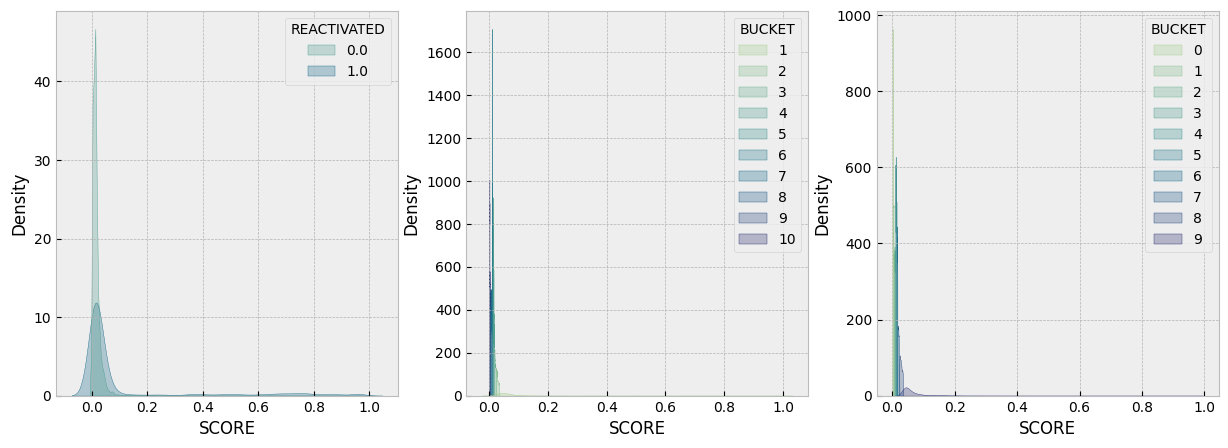

In [36]:
f, axs = plt.subplots(1,3,figsize=(15,5))
sns.kdeplot(d1, x='SCORE', hue='REACTIVATED', fill=True, common_norm=False, alpha=0.3, linewidth=0.3, palette='crest', ax=axs[0])
sns.kdeplot(d1, x='SCORE', hue='BUCKET', fill=True, common_norm=False, alpha=0.3, linewidth=0.3, palette='crest', ax=axs[1])
sns.kdeplot(d2, x='SCORE', hue='BUCKET', fill=True, common_norm=False, alpha=0.3, linewidth=0.3, palette='crest', ax=axs[2])
plt.show()

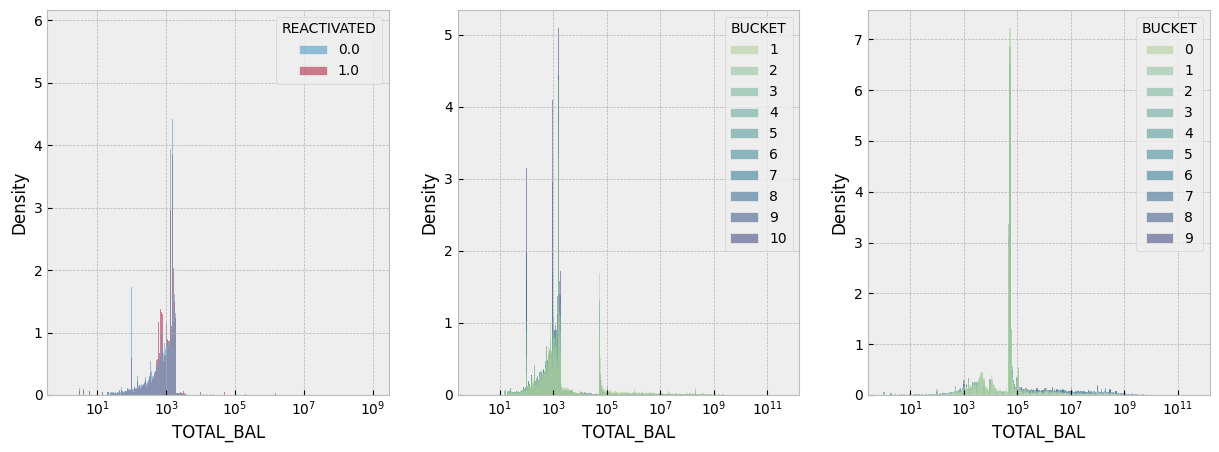

In [37]:
f, axs = plt.subplots(1,3,figsize=(15,5))
sns.histplot(d1, x='TOTAL_BAL', hue='REACTIVATED', log_scale=True, stat='density', common_norm=False,ax=axs[0])
sns.histplot(d1, x='TOTAL_BAL', hue='BUCKET', log_scale=True, stat='density', common_norm=False,palette='crest',ax=axs[1])
sns.histplot(d2, x='TOTAL_BAL', hue='BUCKET', log_scale=True, stat='density', common_norm=False,palette='crest',ax=axs[2])
plt.show()

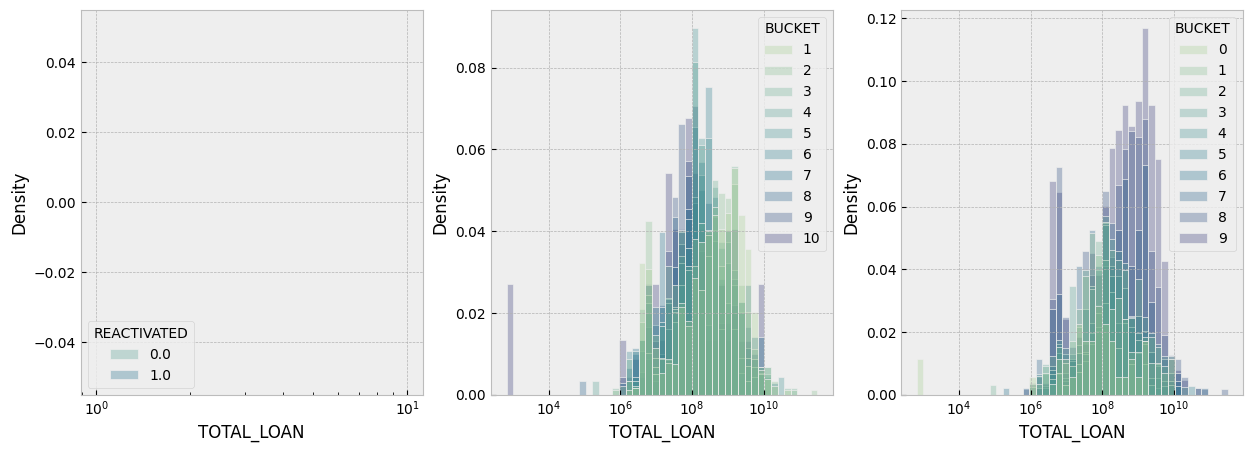

In [38]:
f, axs = plt.subplots(1,3,figsize=(15,5))
sns.histplot(d1, x='TOTAL_LOAN', hue='REACTIVATED', log_scale=True, stat='density', palette='crest', alpha=0.3, ax=axs[0])
sns.histplot(d1, x='TOTAL_LOAN', hue='BUCKET', log_scale=True, stat='density', palette='crest', alpha=0.3, ax=axs[1])
sns.histplot(d2, x='TOTAL_LOAN', hue='BUCKET', log_scale=True, stat='density',palette='crest', alpha=0.3, ax=axs[2])
# axs[0].set_xlim([0, 1e10])
# axs[1].set_xlim([0, 1e10])
plt.show()

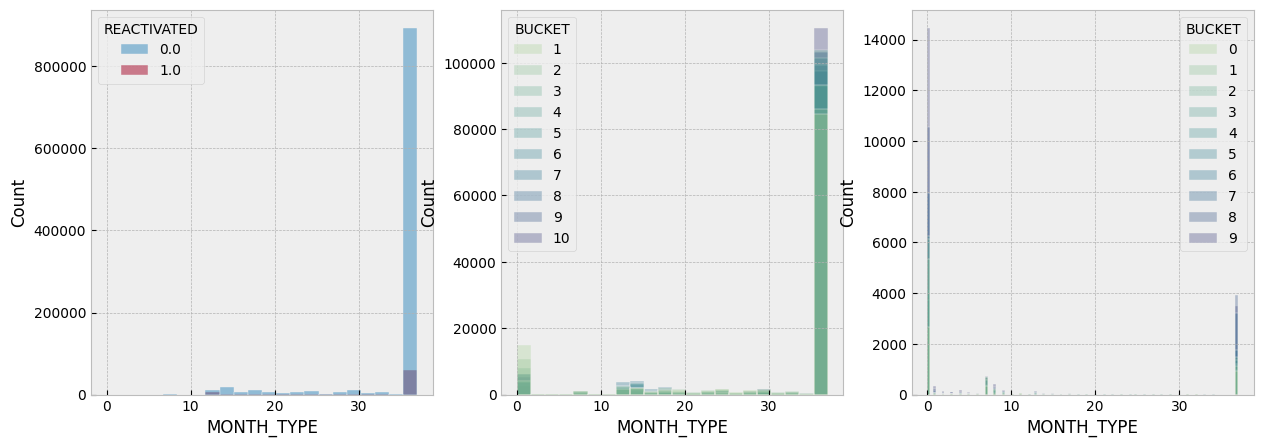

In [39]:
f, axs = plt.subplots(1,3,figsize=(15,5))
sns.histplot(d1, x='MONTH_TYPE', hue='REACTIVATED', fill=True, stat='count',common_norm=True, linewidth=0.3,ax=axs[0])
sns.histplot(d1, x='MONTH_TYPE', hue='BUCKET', fill=True, stat='count',common_norm=True, alpha=0.3, linewidth=0.3,palette='crest', ax=axs[1])
sns.histplot(d2, x='MONTH_TYPE', hue='BUCKET', fill=True, stat='count',common_norm=True, alpha=0.3, linewidth=0.3,palette='crest', ax=axs[2])
plt.show()


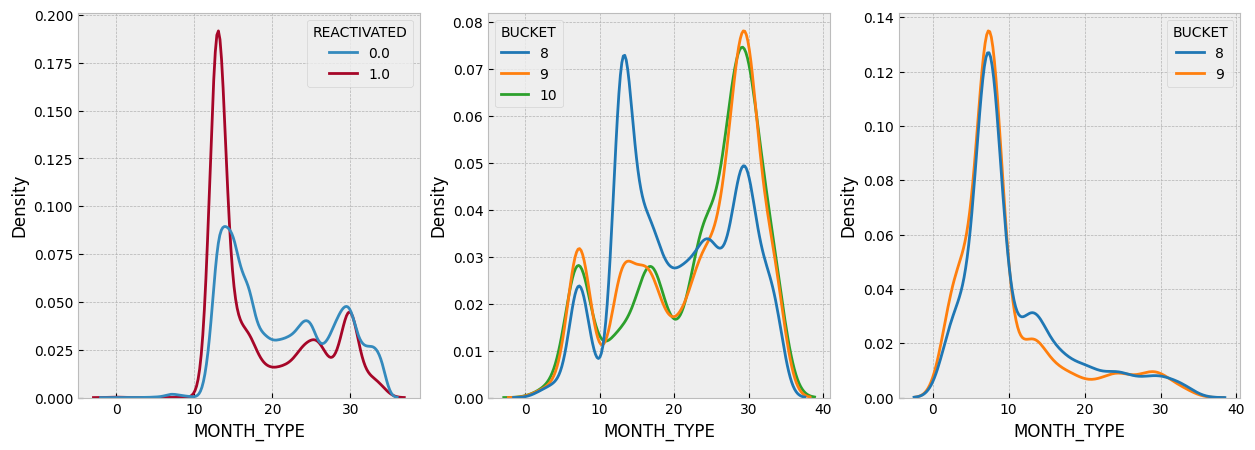

In [40]:
f, axs = plt.subplots(1,3,figsize=(15,5))
d1['MONTH_TYPE'] = d1['MONTH_TYPE'].astype(int)
d2['MONTH_TYPE'] = d2['MONTH_TYPE'].astype(int)

sns.kdeplot(d1[d1['MONTH_TYPE']<37],x='MONTH_TYPE', hue='REACTIVATED',common_norm=False,ax=axs[0])
tmp = d1[(d1['BUCKET']>7) & (d1['MONTH_TYPE']<37) & (d1['MONTH_TYPE']>1)].copy()
sns.kdeplot(tmp,x='MONTH_TYPE', hue='BUCKET',common_norm=False, palette='tab10',ax=axs[1])
sns.kdeplot(d2[(d2['MONTH_TYPE']<37) & (d2['MONTH_TYPE']>1) & (d2['BUCKET']>7)],x='MONTH_TYPE', hue='BUCKET',common_norm=False, palette='tab10',ax=axs[2])
plt.show()

In [41]:
d2.sort_values(by='SCORE', ascending=False)

,AREA_NAME,SUB_BRANCH_CDE,SUB_BRANCH_NAME,CUSTOMER_CDE,FULL_NAME,EMAIL,MOBILE_PHONE,CUST_TYPE,CUST_STATUS,CUST_OPEN_DT,...,TOTAL_BAL,TOTAL_LOAN,LASTEST_TRANS_DT,MONTH_TYPE,DAO_CDE,CASA_DAY_SINCE_LAST_TXN,SCORE,RANK,REACTIVATED,BUCKET
408,KV MIEN BAC,VN0011911,CHI NHANH THANH HOA,18533085,LE HUL8RWUV34ET,lehxxxxxxx@icloud.com,093xxxxxx48,CN,NGU DONG,2023-10-30,...,0.0,0,2023-10-31,37,17801,1095,0.966216,411,NaN,9
2388,KV MIEN BAC,VN0013401,CHI NHANH PHU THO,18534820,LUONGCP2VL21QIE,ABCxxxxxxx@SACOMBANK.COM,096xxxxxx43,CN,NGU DONG,2023-10-31,...,0.0,0,2023-10-31,37,79915,1095,0.895415,2376,NaN,9
2566,KV MIEN BAC,VN0011791,CHI NHANH HAI DUONG,18532779,HOANGE8OOJ3MIZR,,086xxxxxx22,CN,NGU DONG,2023-10-30,...,0.0,0,2023-10-31,37,55917,1095,0.892426,2527,NaN,9
3302,KV MIEN BAC,VN0013401,CHI NHANH PHU THO,18525171,NGUYEMPFM8R34OY,ABCxxxxxxx@SACOMBANK.COM,097xxxxxx29,CN,NGU DONG,2023-10-27,...,0.0,0,2023-10-31,37,50784,1095,0.876971,3275,NaN,9
3885,KV TP.HA NOI,VN0011311,CHI NHANH HA NOI,18509714,LUU VYARUVF88PY,NAMxxxxxxx@GMAIL.COM,035xxxxxx06,CN,NGU DONG,2023-10-23,...,5.0,0,2023-11-01,0,71020,1,0.862272,3885,NaN,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9268672,KV NAM TRUNG BO - TAY NGUYEN,VN0011588,PGD VAN NINH,6244409,TRAN IUJ6SRXPIP,DUNxxxxxxx@YAHOO.COM,097xxxxxx35,CN,NGU DONG,2015-03-19,...,0.0,0,2023-03-24,37,19238,1095,0.000211,8981929,NaN,0
9268680,KV MIEN BAC,VN0011911,CHI NHANH THANH HOA,1471196,NGUYER4VFIXL9JY,ABCxxxxxxx@SACOMBANK.COM,082xxxxxx48,CN,DONG BANG,2009-09-29,...,81758.0,0,2020-01-15,37,11704,1095,0.000187,8981937,NaN,0
9268686,KV NAM TRUNG BO - TAY NGUYEN,VN0011581,CHI NHANH KHANH HOA,4970279,NGUYE40RCC0IUXC,,039xxxxxx63,CN,DONG BANG,2014-03-29,...,73719.0,0,2023-11-01,37,23664,1095,0.000169,8981943,NaN,0
9268687,KV NAM TRUNG BO - TAY NGUYEN,VN0011589,PGD DIEN KHANH,4657737,HUYNHDEGT2Q7ZIM,ABCxxxxxxx@SACOMBANK.COM,093xxxxxx87,CN,DONG BANG,2013-11-29,...,78638.0,602664200,2023-10-31,37,13065,1095,0.000167,8981944,NaN,0


<Axes: xlabel='MONTH_TYPE', ylabel='Percent'>

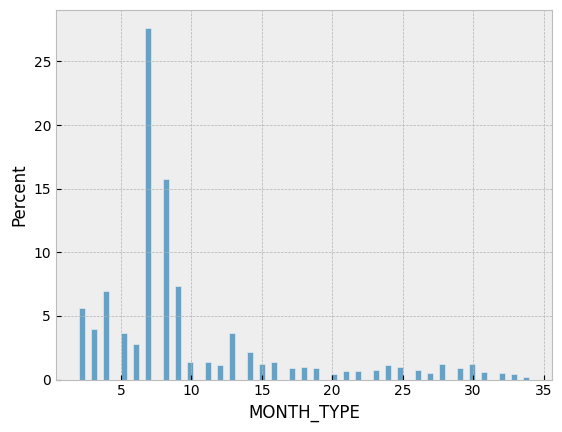

In [42]:
sns.histplot(d2[(d2['BUCKET']==9) & (d2['MONTH_TYPE']>1)& (d2['MONTH_TYPE']<37)], x='MONTH_TYPE',stat='percent')